1.Persiapan data dan prossesing

In [23]:
import pandas as pd
import re


df = pd.read_csv(
    r"C:\Users\user\OneDrive\Documents\TA-13mesin\dataset_komentar_instagram_cyberbullying.csv",
 
)

df.head()




,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [24]:
df.info()
df.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      400 non-null    int64 
 1   Sentiment               400 non-null    object
 2   Instagram Comment Text  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


Index(['Id', 'Sentiment', 'Instagram Comment Text'], dtype='object')

In [33]:
#mapping label
df['sentiment_label'] = df['Sentiment'].map({
    'negative': 0,
    'positive': 1
})

df[['Sentiment', 'sentiment_label']].head()



,Sentiment,sentiment_label
0,negative,0
1,negative,0
2,negative,0
3,negative,0
4,negative,0


In [27]:
#casefolding
import re

def clean_text(text):
    text = text.lower()                          # case folding
    text = re.sub(r'http\S+', '', text)          # hapus URL
    text = re.sub(r'@\w+', '', text)             # hapus mention
    text = re.sub(r'#\w+', '', text)             # hapus hashtag
    text = re.sub(r'[^a-z\s]', '', text)         # hapus angka & simbol
    text = re.sub(r'\s+', ' ', text).strip()     # spasi berlebih
    return text

df['clean_text'] = df['Instagram Comment Text'].apply(clean_text)

df[['Instagram Comment Text', 'clean_text']].head()


,Instagram Comment Text,clean_text
0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,username tolol gak ada hubungan nya keguguran ...
1,Geblek lo tata...cowo bgt dibela2in balikan......,geblek lo tatacowo bgt dibelain balikanhadewwn...
2,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kmrn termewek skr lengket lg duhhh kok labil b...
3,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kalau kesel dengan att nya gausah ke a...
4,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadewwwww permpuan itu lgsakit jiwaknp harus d...


In [30]:
#stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stemmer = StemmerFactory().create_stemmer()
df['clean_text'] = df['clean_text'].apply(stemmer.stem)

df['clean_text'].head()


0    username tolol gak hubung nya gugur dgn pake h...
1    geblek lo tatacowo bgt bain balikanhadewwntar ...
2    kmrn mewek skr lengket lg duhhh kok labil bgt ...
3    inti kalau kesel att nya gausah anak kasi buat...
4    hadewwwww permpuan lgsakit jiwaknp dia yg jd p...
Name: clean_text, dtype: object

In [29]:
#stopword removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

df['clean_text'] = df['clean_text'].apply(stopword_remover.remove)
df['clean_text'].head()


0    username tolol gak hubungan nya keguguran dgn ...
1    geblek lo tatacowo bgt dibelain balikanhadewwn...
2    kmrn termewek skr lengket lg duhhh kok labil b...
3    intinya kalau kesel att nya gausah anaknya kas...
4    hadewwwww permpuan lgsakit jiwaknp dia yg jd p...
Name: clean_text, dtype: object

In [31]:
#data akhir
X = df['clean_text']
y = df['sentiment_label']

X.head(), y.head()


(0    username tolol gak hubung nya gugur dgn pake h...
 1    geblek lo tatacowo bgt bain balikanhadewwntar ...
 2    kmrn mewek skr lengket lg duhhh kok labil bgt ...
 3    inti kalau kesel att nya gausah anak kasi buat...
 4    hadewwwww permpuan lgsakit jiwaknp dia yg jd p...
 Name: clean_text, dtype: object,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: sentiment_label, dtype: int64)

2. Feature Extraction: TF-IDF

In [32]:
#transformasi tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(X)

X_tfidf.shape


(400, 5000)

3.Implementasi SVM dan tunning

In [34]:
#split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((320, 5000), (80, 5000))

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Model SVM awal (default)
svm_baseline = SVC()
svm_baseline.fit(X_train, y_train)

# Prediksi
y_pred_baseline = svm_baseline.predict(X_test)

# Evaluasi
print("Akurasi SVM Baseline:", accuracy_score(y_test, y_pred_baseline))
print(classification_report(y_test, y_pred_baseline))


Akurasi SVM Baseline: 0.825
              precision    recall  f1-score   support

           0       0.80      0.88      0.83        40
           1       0.86      0.78      0.82        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80



In [35]:
#SVM modelling
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

y_pred_linear = svm_linear.predict(X_test)

print("Akurasi SVM Linear:", accuracy_score(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))


Akurasi SVM Linear: 0.825
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        40
           1       0.81      0.85      0.83        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80



In [ ]:
#svm kernel RBF
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

y_pred_rbf = svm_rbf.predict(X_test)

print("Akurasi SVM RBF:", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


Akurasi SVM RBF: 0.825
              precision    recall  f1-score   support

           0       0.80      0.88      0.83        40
           1       0.86      0.78      0.82        40

    accuracy                           0.82        80
   macro avg       0.83      0.82      0.82        80
weighted avg       0.83      0.82      0.82        80



4.Evaluasi dan Visualisasi

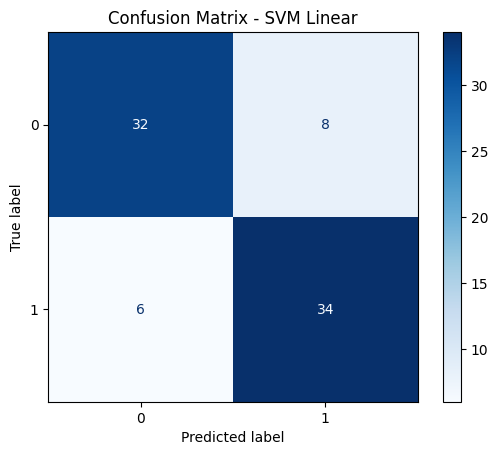

In [38]:
#cofusion matrixs
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_linear,
    cmap='Blues'
)

plt.title("Confusion Matrix - SVM Linear")
plt.show()


In [39]:
#analisis eror
import numpy as np

error_idx = np.where(y_test != y_pred_linear)[0]

for i in error_idx[:5]:
    print("Kalimat:", X.iloc[y_test.index[i]])
    print("Label Asli:", y_test.iloc[i])
    print("Prediksi:", y_pred_linear[i])
    print("-"*60)


Kalimat: anjir tonton yg sangat mutu
Label Asli: 0
Prediksi: 1
------------------------------------------------------------
Kalimat: jeleklecekbantet
Label Asli: 0
Prediksi: 1
------------------------------------------------------------
Kalimat: moga pelakor kena karma moga karma yg tinggal istri yg bwrjuang dg dr nol tp sukses selingkuh sok jd kuasa istri
Label Asli: 0
Prediksi: 1
------------------------------------------------------------
Kalimat: kasi anak jgn sampek anak rusak jugak kek emaknya yaa
Label Asli: 1
Prediksi: 0
------------------------------------------------------------
Kalimat: sikat abiss lahh orng sial kaya gin pimpin negara sendiri gak hormatin jgn mentang bapak president terlalu baik jadi sembarangin marah gak hina pimpin kita sendiri harap segera tindak hukum orng
Label Asli: 0
Prediksi: 1
------------------------------------------------------------


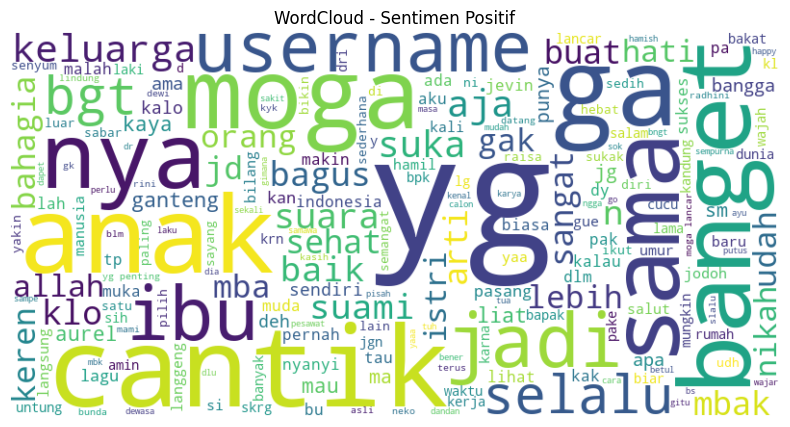

In [40]:
#wordcloud sentimen positif
from wordcloud import WordCloud

text_positive = " ".join(
    df[df['sentiment_label'] == 1]['clean_text']
)

wc_positive = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text_positive)

plt.figure(figsize=(10,5))
plt.imshow(wc_positive, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Sentimen Positif")
plt.show()


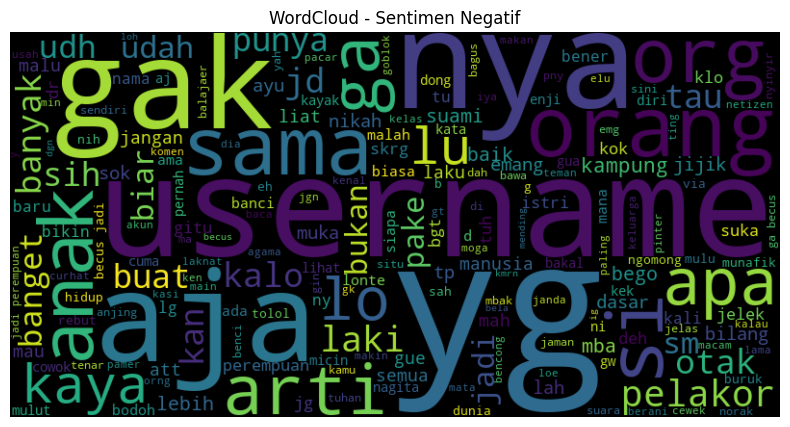

In [41]:
#wordcloud sentimen negatif
text_negative = " ".join(
    df[df['sentiment_label'] == 0]['clean_text']
)

wc_negative = WordCloud(
    width=800,
    height=400,
    background_color='black'
).generate(text_negative)

plt.figure(figsize=(10,5))
plt.imshow(wc_negative, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Sentimen Negatif")
plt.show()


In [42]:
#simpan model
import joblib

joblib.dump(svm_linear, "model.pkl")
joblib.dump(tfidf, "tfidf.pkl")


['tfidf.pkl']